# OpenCV

In [ ]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit since some none-free features are not avilable
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 156kB/s 
     |████████████████████████████████| 14.8MB 183kB/s 
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


# Extract Data

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

files = zf.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()

# File Organizing
>splits indices for a folder into train and test indices with random sampling

In [ ]:
## input: folder path
## output: train and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.85*n))  # random awal = 0.7 --> 0.85

    ## separate remaining into test
    test = list(set(full_set)-set(train))
       
    return(train,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [ ]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','test']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('dataset',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "dataset/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    test_dest = "dataset/test/"+waste_type
    move_files(test_source_files,test_dest)

#Training

In [ ]:
import cv2
import numpy as np
import os


#Get the training classes names and store them in a list
#Here we use folder names for class names
train_path = './dataset/train'
training_names = os.listdir(train_path)

# Get path to all images and save them in a list
# image_paths and the corresponding label in image_paths
image_paths = []
image_classes = []
class_id = 0

#To make it easy to list all file names in a directory let us define a function
def imglist(path):    
    return [os.path.join(path, f) for f in os.listdir(path)]

#Fill the placeholder empty lists with image path, classes, and add class ID number
for training_name in training_names:
    dir = os.path.join(train_path, training_name)
    class_path = imglist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

In [ ]:
#import numpy as np
#from sklearn.decomposition import PCA

# Create feature extraction and keypoint detector objects using SIFT    
# Create List where all the descriptors will be stored
des_list = []
sift = cv2.xfeatures2d.SIFT_create()

for image_path in image_paths:
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    kpts, des = sift.detectAndCompute(im, None)
    if len(kpts) < 1:
        no_kpts = np.zeros((1, sift.descriptorSize()), np.float32)
        des_list.append((image_path, no_kpts))
        #print(image_path)
    else:
        des_list.append((image_path, des))   

./dataset/train/cardboard/cardboard387.jpg
./dataset/train/plastic/plastic2.jpg
./dataset/train/paper/paper385.jpg
./dataset/train/paper/paper539.jpg


In [ ]:
# Stack all the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for image_path, descriptor in des_list[1:]:
    descriptors = np.vstack((descriptors, descriptor))

#kmeans works only on float, so convert integers to float
descriptors_float = descriptors.astype(float)

In [ ]:
# Perform k-means clustering and vector quantization
from scipy.cluster.vq import kmeans, vq

k = 250  #k means awal 250 clusters
voc, variance = kmeans(descriptors_float, k, 1)

In [ ]:
# Calculate the histogram of features and represent them as vector
#vq Assigns codes from a code book to observations.
#Returns codendarray & distndarray
#A length M array holding the code book index for each observation.
#The distortion (distance) between the observation and its nearest code.

im_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1],voc)
    for w in words:
        im_features[i][w] += 1

[[ 5.  2.  2. ...  0.  2.  0.]
 [ 5.  0.  1. ...  1.  1.  4.]
 [14.  2.  0. ...  4.  3.  3.]
 ...
 [ 0.  3.  0. ...  1.  4.  2.]
 [ 1.  1.  0. ...  3.  1.  2.]
 [ 2.  3.  3. ...  0.  2.  4.]]


In [ ]:
vari = im_features.var()
print(vari)
g = 1 / (250 * vari)
print(g)

16.46331
0.0002429645035704041


In [ ]:
#Train an algorithm to discriminate vectors corresponding to positive and negative training images
# Train the SVM
from sklearn import svm
clf = svm.SVC(decision_function_shape='ovr', kernel='rbf', C=10, gamma=1 / (250 * im_features.var())) #decision_function_shape='ovr', kernel='rbf', max_iter=50000
#clf = svm.SVC()   #C=100,gamma=0.001 
clf.fit(im_features, np.array(image_classes))

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0002429645035704041,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [ ]:
#Report true class names so they can be compared with predicted classes
true_class =  [training_names[i] for i in image_classes]
# Perform the predictions and report predicted class names. 
predictions =  [training_names[i] for i in clf.predict(im_features)]

#Print the true class and Predictions 
print ("true_class ="  + str(true_class))
print ("prediction ="  + str(predictions))

true_class =['cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard',

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

print(classification_report(true_class, predictions, digits=3))

              precision    recall  f1-score   support

   cardboard      0.883     0.863     0.873       342
       glass      0.737     0.936     0.825       425
       metal      0.975     0.897     0.934       348
       paper      0.951     0.919     0.934       504
     plastic      0.895     0.817     0.854       409
       trash      0.944     0.733     0.825       116

    accuracy                          0.880      2144
   macro avg      0.898     0.861     0.874      2144
weighted avg      0.891     0.880     0.882      2144



In [ ]:
# Save the SVM
#Joblib dumps Python object into one file
from sklearn.externals import joblib
joblib.dump((clf, training_names, k, voc), "trashnet.pkl", compress=3)  
#joblib.dump((clf, training_names, stdSlr, k, voc), "trashnet.pkl", compress=3)  

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['trashnet.pkl']

#Testing

In [ ]:
import pylab as pl
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
#Load the classifier, class names, scaler, number of clusters and vocabulary 
#from stored pickle file (generated during training)
clf, classes_names, k, voc = joblib.load("trashnet.pkl")
#clf, classes_names, stdSlr, k, voc = joblib.load("trashnet.pkl")

#Get the path of the testing image(s) and store them in a list
test_path = './dataset/test' 
testing_names = os.listdir(test_path)

#Get path to all images and save them in a list
#image_paths and the corresponding label in image_paths
image_paths = []
image_classes = []
class_id = 0

In [ ]:
#To make it easy to list all file names in a directory let us define a function
def imglist(path):
    return [os.path.join(path, f) for f in os.listdir(path)]

#Fill the placeholder empty lists with image path, classes, and add class ID number
for testing_name in testing_names:
    dir = os.path.join(test_path, testing_name)
    class_path = imglist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

In [ ]:
# Create feature extraction and keypoint detector objects using SIFT 
# Create List where all the descriptors will be stored
des_list = []
sift = cv2.xfeatures2d.SIFT_create()

for image_path in image_paths:
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    kpts, des = sift.detectAndCompute(im, None) 
    if len(kpts) < 1:
        no_kpts = np.zeros((1, sift.descriptorSize()), np.float32)
        des_list.append((image_path, no_kpts))
        #print(image_path)
    else:
        des_list.append((image_path, des))  

In [ ]:
# Stack all the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for image_path, descriptor in des_list[0:]:
    descriptors = np.vstack((descriptors, descriptor)) 

In [ ]:
# Calculate the histogram of features
#vq Assigns codes from a code book to observations.
from scipy.cluster.vq import vq    
test_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1],voc)
    for w in words:
        test_features[i][w] += 1

#Evaluation

In [ ]:
#Report true class names so they can be compared with predicted classes
true_class =  [classes_names[i] for i in image_classes]
# Perform the predictions and report predicted class names. 
predictions =  [classes_names[i] for i in clf.predict(test_features)]

#Print the true class and Predictions 
print ("true_class ="  + str(true_class))
print ("prediction ="  + str(predictions))

true_class =['cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'meta

In [ ]:
print(classification_report(true_class, predictions, digits=3))

              precision    recall  f1-score   support

   cardboard      0.700     0.689     0.694        61
       glass      0.484     0.592     0.533        76
       metal      0.627     0.516     0.566        62
       paper      0.732     0.789     0.759        90
     plastic      0.587     0.603     0.595        73
       trash      0.571     0.190     0.286        21

    accuracy                          0.621       383
   macro avg      0.617     0.563     0.572       383
weighted avg      0.624     0.621     0.615       383



In [ ]:
cm = confusion_matrix(true_class, predictions)
print (cm)

#To make it easy to understand the accuracy let us print the confusion matrix
def showconfusionmatrix(cm):
    pl.matshow(cm)
    pl.title('Confusion matrix')
    pl.colorbar()
    pl.show()

showconfusionmatrix(cm)

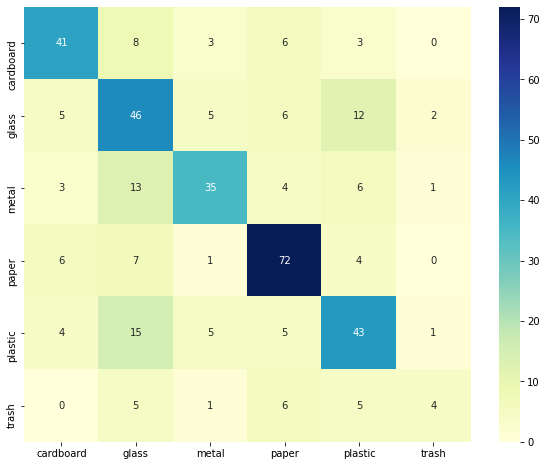

In [ ]:
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")